In [1]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
import numpy as np

Using TensorFlow backend.


In [2]:
model = InceptionResNetV2(weights='imagenet', input_shape=(228,228,3), include_top=False)

In [3]:
import cv2
import matplotlib.pyplot as plt
import os

In [4]:
path = '/home/wvillegas/datasets/DHARMaBuds/corpus-26000-bc/'

In [5]:
import pandas as pd
csv_data = pd.read_csv(path+'corpus-26000.csv')

In [6]:
data = csv_data[['imageName', 'class', 'radio']]

In [7]:
patch_list = []
label_list = []
for index, row in data.iterrows():
    img = cv2.imread(path + row['imageName'])
    if row['radio'] > 114:
        img = cv2.resize(img, (228,228),cv2.INTER_AREA)
    else:
        img = cv2.resize(img, (228,228),cv2.INTER_LINEAR)
    cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
    patch_list.append(img)
    if row['class'] == True:
        label_list.append(1)
    else:
        label_list.append(0)
    if len(patch_list) == 10000:
        break
print(str(len(patch_list)) + ' samples preprocessed')

10000 samples preprocessed


In [8]:
def shuffle_dataset(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

In [9]:
patch = np.asarray(patch_list)
patch_labels = np.asarray(label_list)
shuffle_dataset(patch, patch_labels)

In [10]:
from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(patch, patch_labels, test_size=0.15)

In [11]:
train_labels.shape

(8500,)

Let's stack some FC layers to predict binary classes

In [12]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import SGD

In [13]:
flatten = Flatten()(model.output)
fc1 = Dense(4096, activation='relu')(flatten)
fc2 = Dense(1024, activation='relu')(fc1)
final = Dense(1,activation='sigmoid')(fc2)
modelo = Model(model.input, final) 


In [14]:
optim = SGD(lr=0.001, momentum=0.9)

In [15]:
modelo.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
class_weight = {0: 1.,
                1: 3.}

In [17]:
history = modelo.fit(x=train, y=train_labels,epochs=3, batch_size=20, class_weight=class_weight, validation_split=0.1)

Train on 7650 samples, validate on 850 samples
Epoch 1/3
7650/7650 [==============================] - 165s 22ms/step - loss: 0.1182 - acc: 0.9761 - val_loss: 0.0793 - val_acc: 0.9871
Epoch 2/3
7650/7650 [==============================] - 126s 16ms/step - loss: 0.0186 - acc: 0.9970 - val_loss: 0.0178 - val_acc: 0.9965
Epoch 3/3
7650/7650 [==============================] - 126s 17ms/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0301 - val_acc: 0.9929


In [18]:
modelo.evaluate(test,test_labels)

1500/1500 [==============================] - 6s 4ms/step


[0.018059370514102436, 0.9953333333333333]

Text(0.5,1,'Train Acc vs Val Acc')

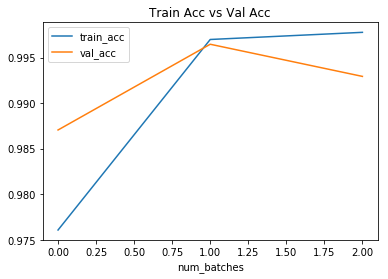

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.xlabel('num_batches')
plt.title('Train Acc vs Val Acc')

Text(0.5,1,'train_loss vs val_loss')

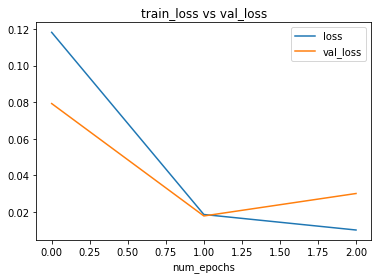

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('num_epochs')
plt.legend(['loss', 'val_loss'])
plt.title('train_loss vs val_loss')

Text(0.5,1,'0')

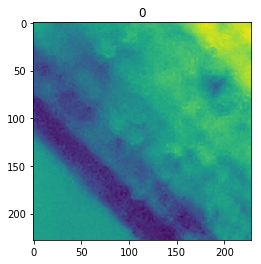

In [21]:
asd = 771
plt.imshow(train[asd,:,:,0])
plt.title(train_labels[asd])

In [22]:
#def preprocesser(img_path):
#    img = cv2.imread(path + row['imageName'])
#    if img.shape[0] > 228 && img.shape[1] > 228: 
#        #shrink
#        img = cv2.resize(img, (228,228),cv2.INTER_AREA)
#    else: #zoom
#        img = cv2.resize(img, (228,228),cv2.INTER_LINEAR)
#    cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
#    return img